 ### 1) Libraries

In [4]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import numpy as np

from matplotlib import pyplot as plt

### 2) Functions

In [5]:
def get_data(path):
    data = pd.read_csv(path)
    data['date'] = pd.to_datetime(data['date'])
    
    return data
    
def transformation_data(data):
    # converting sqft to m2
    data['m2_living'] = data['sqft_living'] * 0.092903
    data['m2_lot'] = data['sqft_lot'] * 0.092903
    data['m2_above'] = data['sqft_above'] * 0.092903
    data['m2_basement'] = data['sqft_basement'] * 0.092903
    
    # removing columns with sqft
    data = data.drop(['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15'], axis=1)
    
    # new features
    data['old'] = data['yr_built'].apply(lambda x: 'yes' if x <= 1955 else 'no')

    data['renovated'] = data['yr_renovated'].apply(lambda x: 'yes' if x > 2009 else 'no')
    
    return data

def treatment_data(data):
    
    # removing repeated ids and keeping the last one
    data = data.drop_duplicates(subset = ['id'], keep = 'last')
    
    # excluding the row with 33 bedrooms
    data = data.drop(index=15870)
    
    # removing outliers by using interquartile
    cols = ['price','m2_lot']
    Q1 = data[cols].quantile(0.25)
    Q3 = data[cols].quantile(0.75)
    IQR = Q3 - Q1

    data = data[~((data[cols] < (Q1 - 1.5 * IQR)) |(data[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
      
    return data

### 3) Data Extraction

In [6]:
# Data Path and 
path = 'kc_house_data.csv'
data = get_data(path)

# Supressing Scientific Notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### 3.1) Exploratory Data Analysis (EDA)

In [7]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00
mean,4580301520.86,540088.14,3.37,2.11,2079.90,15106.97,1.49,0.01,0.23,3.41,7.66,1788.39,291.51,1971.01,84.40,98077.94,47.56,-122.21,1986.55,12768.46
std,2876565571.31,367127.20,0.93,0.77,918.44,41420.51,0.54,0.09,0.77,0.65,1.18,828.09,442.58,29.37,401.68,53.51,0.14,0.14,685.39,27304.18
min,1000102.00,75000.00,0.00,0.00,290.00,520.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00
25%,2123049194.00,321950.00,3.00,1.75,1427.00,5040.00,1.00,0.00,0.00,3.00,7.00,1190.00,0.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00
50%,3904930410.00,450000.00,3.00,2.25,1910.00,7618.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00
75%,7308900445.00,645000.00,4.00,2.50,2550.00,10688.00,2.00,0.00,0.00,4.00,8.00,2210.00,560.00,1997.00,0.00,98118.00,47.68,-122.12,2360.00,10083.00
max,9900000190.00,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,4820.00,2015.00,2015.00,98199.00,47.78,-121.31,6210.00,871200.00


In [8]:
# Verifying the row with 33 bedrooms
data.loc[data['bedrooms'] == 33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15870,2402100895,2014-06-25,640000.00,33,1.75,1620,6000,1.00,0,0,...,7,1040,580,1947,0,98103,47.69,-122.33,1330,4700


In [9]:
# Verifying if there are duplicated rows
duplicates = data[data.duplicated()]
print(len(duplicates))

0


In [10]:
# Verifying if there are rows with the same IDs
duplicates = data[data.duplicated(subset=['id'])]
print(len(duplicates))

177


### 4) Data Transformation and Treatment

In [11]:
data = transformation_data(data)
data = treatment_data(data)

### 5) Testing some Business Hypothesis

- First Hypothesis: The best time to sell Real Estate is during the Summer Season.
- Second Hypothesis : Houses with waterview are 50% more expensive.
- Third Hypothesis: New houses have higher prices than old ones.
- Fourth Hypothesis: The price of the houses gets higher from year to year.
- Fifth Hypothesis: For every half level added to the house, it's price raises by 20%.
- Sixth Hypothesis: Recent renovated houses got prices 20% higher.
- Seventh Hypothesis: For every bathroom, the house price raises 10%
- Eight Hypothesis: Every 1 level in condition, the price raises by 10%.

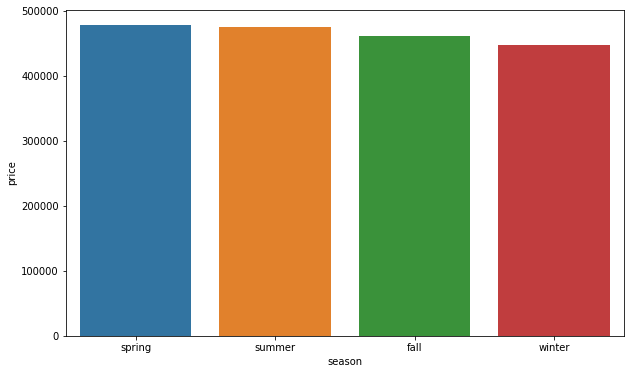

In [79]:
# First Hypothesis: The best time to sell Real Estate is during the Summer Season.
data['month'] = data['date'].dt.month
data['season'] = data['month'].apply(lambda x: 'spring' if (x >= 3) & (x <= 5) else
                                              'summer' if (x >= 6) & (x <= 8)  else
                                              'fall' if (x >= 9) & (x <= 11)   else 'winter')

h1 = data[['price','season']].groupby('season').mean().reset_index().sort_values('price', ascending=False)

plt.figure(figsize=(10,6))
plot = sns.barplot(x=h1['season'], y=h1['price'])



False: the season where you can get maximum profit on your sales is Spring.

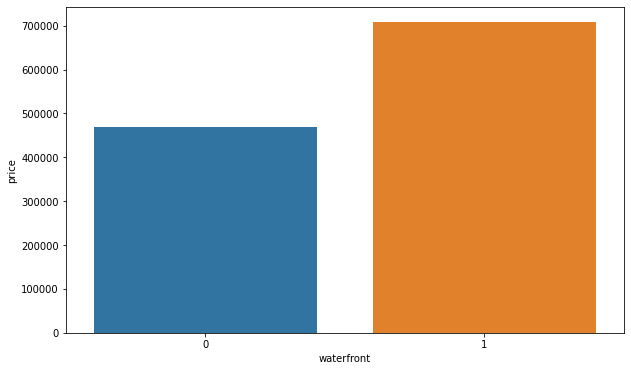

In [80]:
# Second Hypothesis : Houses with waterview are 50% more expensive.
data[['price','waterfront']].groupby('waterfront').mean().reset_index()

h2 = data[['price','waterfront']].groupby('waterfront').mean().reset_index()

plt.figure(figsize=(10,6))
plot = sns.barplot(x=h2['waterfront'], y=h2['price'])

True.

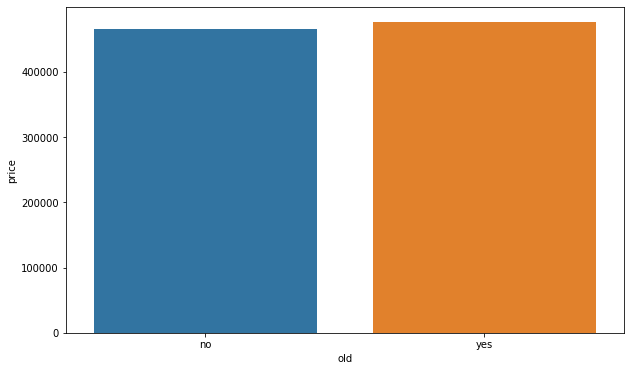

In [81]:
# Third Hypothesis: New houses have higher prices than old ones.
data['old'] = data['yr_built'].apply(lambda x: 'yes' if x <= 1955 else 'no')
h3 = data[['price', 'old']].groupby('old').mean().reset_index()

plt.figure(figsize=(10,6))
plot = sns.barplot(x=h3['old'], y=h3['price'])

False: the house age doesn't affect the price.

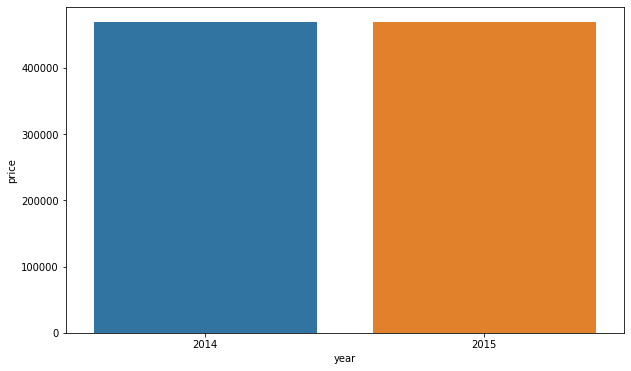

In [82]:
# Fourth Hypothesis: The price of the houses gets higher from year to year.
data['year'] = pd.DatetimeIndex(data['date']).year
h4 = data[['price', 'year']].groupby('year').mean().reset_index()

plt.figure(figsize=(10,6))
plot = sns.barplot(x=h4['year'], y=h4['price'])

False: the price seems to be constant from a year to another.

/home/joaohenritm/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



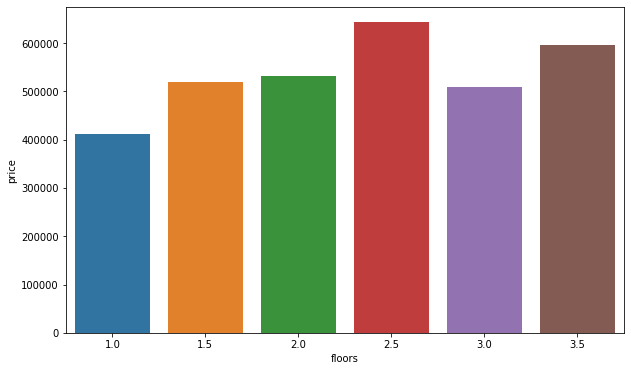

In [77]:
# Fifth Hypothesis: For every half level added to the house, it's price raises by 20%.
variation = data[['price', 'floors']].groupby('floors').mean().reset_index()
variation['price'].pct_change()

h5 = data[['price', 'floors']].groupby('floors').mean().reset_index()
plt.figure(figsize=(10,6))
plot = sns.barplot(x=h5['floors'], y=h5['price'])

False: for every half level added to the house, the price raises 9% in average.

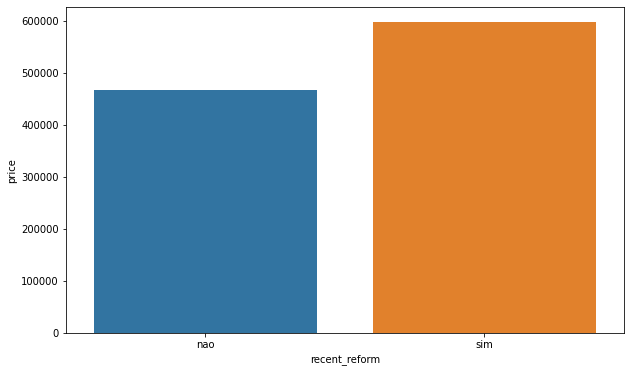

In [83]:
# Sixth Hypothesis: Recent renovated houses got prices 20% higher.
data['recent_reform'] = data['yr_renovated'].apply(lambda x: 'sim' if x > 2009 else 'nao')
variation = data[['recent_reform', 'price']].groupby('recent_reform').mean().reset_index()

variation['price'].pct_change()

h6 = data[['recent_reform', 'price']].groupby('recent_reform').mean().reset_index()
plt.figure(figsize=(10,6))
plot = sns.barplot(x=h6['recent_reform'], y=h6['price'])


False: houses that got recently renovated got prices 28% higher than houses that did not.

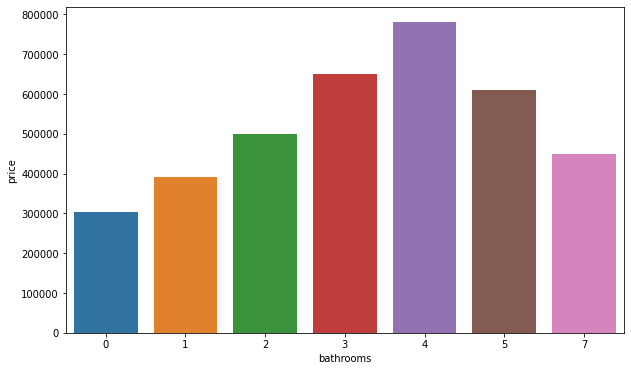

In [84]:
# Seventh Hypothesis: For every bathroom, the house price raises 10%
data = data.astype({"bathrooms":'int'})
variation = data[['price', 'bathrooms']].groupby('bathrooms').mean().reset_index()

variation['price'].pct_change()

h7 = data[['price', 'bathrooms']].groupby('bathrooms').mean().reset_index()
plt.figure(figsize=(10,6))
plot = sns.barplot(x=h7['bathrooms'], y=h7['price'])

True.

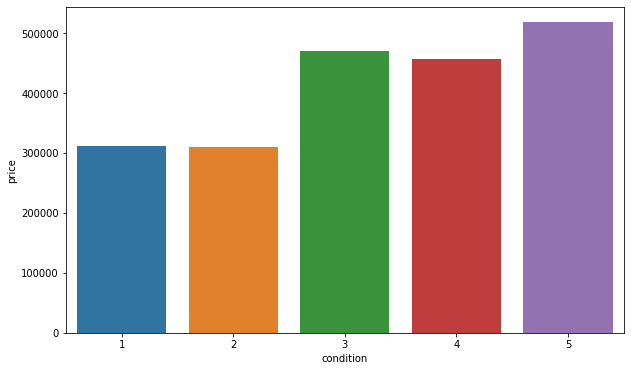

In [85]:
# Eight Hypothesis: Every 1 level in condition, the price raises by 10%.
variation = data[['condition', 'price']].groupby('condition').mean().reset_index()

variation['price'].pct_change()

h8 = data[['price', 'condition']].groupby('condition').mean().reset_index()
plt.figure(figsize=(10,6))
plot = sns.barplot(x=h8['condition'], y=h8['price'])


False: every 1 level in condition, makes the price of the high raises by 15%.

###  6) Some more Data exploration

In [64]:
# The price difference between houses with condition 2 to 3 is extremely high, 51%.
variation = data[['condition', 'price']].groupby('condition').mean().reset_index()
variation['price'].pct_change()

0     NaN
1   -0.00
2    0.51
3   -0.03
4    0.13
Name: price, dtype: float64

In [21]:
# Price difference between houses with 1 to 1.5 floors is 27%.
variation = data[['price', 'floors']].groupby('floors').mean().reset_index()
variation['price'].pct_change()

0     NaN
1    0.27
2    0.02
3    0.21
4   -0.21
5    0.17
Name: price, dtype: float64

In [22]:
# Price difference between houses with 0 to 1 and 2 to 3 bathrooms are 30%.
data = data.astype({"bathrooms":'int'})
variation = data[['price', 'bathrooms']].groupby('bathrooms').mean().reset_index()

variation['price'].pct_change()

0     NaN
1    0.30
2    0.28
3    0.30
4    0.20
5   -0.22
6   -0.26
Name: price, dtype: float64

In [23]:
data[['condition','price']].groupby('condition').mean()

,price
condition,
1,311022.50
2,310449.60
3,469477.42
4,456767.26
5,518032.33


###  7) Useful Insights

1. Buy properties during Winter and Fall.
2. Buy properties with 0 bathrooms and build 1.
3. Buy properties with 1 floor and transform it to a 1.5 floor.
4. Buy properties with condition 2 and renovate until it gets condition 3.

In [24]:
recommended = data.loc[((data['bathrooms'] == 0) | (data['floors'] == 1)) &
                        (data['condition'] == 3)]
                       
price_sell = data['price'] * 1.30

recommended.insert(loc=5, column='Estimated Sell Price', value=price_sell)

In [25]:

recommended = recommended.rename(columns={'id':'ID','date':'Date','price':'Price','bedrooms':'Bedrooms',
                                          'bathrooms':'Bathrooms', 'floors':'Floors', 'condition':'Condition'})

### 8) Business Recommendations

#### The recommendation for the House Rocket:
- Buy properties that fulfill the insights 2, 3 and 4. Renovate the properties and sell for a price at least 40% higher.
- Buy properties that fulfill the insights 2, 3 and 4, don't renovate and sell for a price 10% higher without renovating.
- Try to buy many properties as possible during Winter and Fall season and sell it during Spring and Summer season.

In [26]:
recommended[['ID', 'Price', 'Estimated Sell Price', 'Bedrooms', 'Bathrooms', 'Floors', 'Condition']]

,ID,Price,Estimated Sell Price,Bedrooms,Bathrooms,Floors,Condition
0,7129300520,221900.00,288470.00,3,1,1.00,3
2,5631500400,180000.00,234000.00,2,1,1.00,3
4,1954400510,510000.00,663000.00,3,2,1.00,3
7,2008000270,291850.00,379405.00,3,1,1.00,3
8,2414600126,229500.00,298350.00,3,1,1.00,3
...,...,...,...,...,...,...,...
21504,8682291050,810000.00,1053000.00,2,2,1.00,3
21570,3438501862,330000.00,429000.00,3,2,1.00,3
21602,844000965,224000.00,291200.00,3,1,1.00,3
21610,1523300141,402101.00,522731.30,2,0,2.00,3


In [27]:
recommended.describe()

,ID,Price,Bedrooms,Bathrooms,Estimated Sell Price,Floors,waterfront,view,Condition,grade,...,yr_renovated,zipcode,lat,long,m2_living,m2_lot,m2_above,m2_basement,month,year
count,4852.00,4852.00,4852.00,4852.00,4852.00,4852.00,4852.00,4852.00,4852.00,4852.00,...,4852.00,4852.00,4852.00,4852.00,4852.00,4852.00,4852.00,4852.00,4852.00,4852.00
mean,4715668220.92,396757.81,3.06,1.38,515785.15,1.00,0.00,0.16,3.00,7.08,...,102.17,98091.79,47.57,-122.25,150.13,752.59,117.57,32.56,6.49,2014.36
std,2842674505.78,167451.86,0.89,0.57,217687.42,0.06,0.04,0.59,0.00,0.77,...,440.27,57.99,0.14,0.12,54.79,292.55,34.32,39.00,3.20,0.48
min,3600057.00,83000.00,0.00,0.00,107900.00,1.00,0.00,0.00,3.00,4.00,...,0.00,98001.00,47.19,-122.46,35.30,90.95,35.30,0.00,1.00,2014.00
25%,2297225132.50,270000.00,3.00,1.00,351000.00,1.00,0.00,0.00,3.00,7.00,...,0.00,98034.00,47.48,-122.34,108.70,557.42,93.83,0.00,4.00,2014.00
50%,4058801080.00,368000.00,3.00,1.00,478400.00,1.00,0.00,0.00,3.00,7.00,...,0.00,98106.00,47.57,-122.29,143.07,713.50,113.34,13.01,6.00,2014.00
75%,7452500112.50,485000.00,3.00,2.00,630500.00,1.00,0.00,0.00,3.00,7.00,...,0.00,98133.00,47.70,-122.19,183.02,896.82,134.71,60.39,9.00,2015.00
max,9900000190.00,1110000.00,8.00,4.00,1443000.00,3.50,1.00,4.00,3.00,11.00,...,2015.00,98199.00,47.78,-121.36,470.74,1780.30,320.52,192.31,12.00,2015.00
